# Advanced Machine Learning 3rd Project
### Authors: Guilherme Cepeda - 62931, Pedro Serrano - 54853


In this third assignment, we were asked to apply reinforcement learning to the Mountain Cart problem, from Gymnasium. We will split this in two parts, one where we implement Q-Learning, and one where we implement Deep Q-Learning, as requested in the statement.

In [86]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings as w
import gymnasium as gym
import pickle

import PIL.Image
import tensorflow as tf
from tf_agents.environments import tf_py_environment,suite_gym

import torch
from torch import nn
import torch.nn.functional as F
from collections import deque
import random as r

### Load Data 

For the **Mountain Car reinforcemet learning problem** the challenge lies in the continuous control problem of getting the car to move uphill by applying appropriate forces. There's no randomness in the transitions between states in the same way as it might be in a discrete grid world like FrozenLake. 

In [329]:
env = gym.make('MountainCar-v0', render_mode="rgb_array") # rendered to an rbg array, returned as a NumPy array containing pixel values

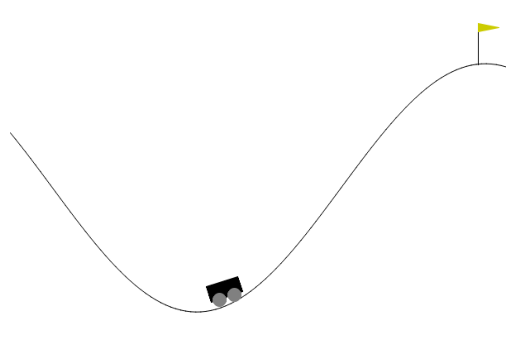

In [330]:
env.reset()
plt.imshow(env.render())
plt.axis('off')
plt.show()

### Exploratory Data Analysis (EDA)

First we started by understanding the possible states and actions of the environment.


#### States


In [10]:
env.observation_space #Position of the car along the x-axis, Min: -1.2 Max: 0.6
                      #Velocity of the car, Min:-0.07 Max: 0.07

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [76]:
env.observation_space.high[0]

0.6

#### Actions

3 actions:
* Drive left
* Stay neutral
* Drive right

In [11]:
print(env.action_space) 
print("\n",env.action_space.n)

Discrete(3)

 3


In [75]:
env.action_space.sample() # generates a random action sample between 0(left), 1 (neutral) and 2(right)


0

In [60]:
env.step(env.action_space.sample())# executes an action

(array([-0.5742453 ,  0.00311769], dtype=float32), -1.0, False, False, {})

### Q - Learning

The **Q-Learning** algorithm is an model-free, off-policy method of doing **Reinforcement Learning**. This means we will not be estimating the transition matrix and the rewards, and will be going straight after an optimal policy.

We have **two environments**, the train and evaluation/test environment as this practice helps ensure that our agent is able to generalize its learned policy to unseen situations during the evaluation/testing phase.

How do we do this?
We create a Q-table, which is a lookup table of states by actions, where, in each entry [state[i], action[i]] we have stored the optimal policy for that specific request. We estimate each Q value as the sum of the immediate reward, plus the maximum Q value of the possible future actions. We usualy add a weight - the discount factor - to this second part to balance out how much we want to reward the current reward. We expect the optimal discount factor in this problem to be fairly high - its like this is most cases, we believe.

As presented in the statement, the space is continuous, so we will need to turn it into a discrete space. 

We use the numpy linspace function to separate the entire range of the position and velocity scalers in equal parts. Here we initilly picked 5 (yes, it was very small), and tested bigger and bigger numbers until reaching the optimum value.



Here is where we initialize some of the models parameters

The Q-table starts off by all zeros - we also tested by starting with random numbers, but it didnt improve (later we realized this was useless, since we were starting our epsilon at 1)

The treshold is an alternitive to having a fixed number of episodes - instead we pick a very low treshold, and if we dont improve more than the threshold, we stop running.

We have talked about the discount factor before, but here we also initizalize the learning rate - still dont know what this is specifically.

We start our epsilon at 1, and keep decreasing with every episode. The epsilon gives our how much of our decision is going to be random, meaning we start off with a completely random decision, and make them less random with every episode by using our Q-table

The rewards per episode is just an array, initialized at all zeros, where we will be updating our rewards.

In [331]:
def q_learning_test(training, episodes, environment):

    # Divide position and velocity into segments
    position_space = np.linspace(environment.observation_space.low[0], environment.observation_space.high[0], 20)    # position between -1.2 and 0.6
    velocity_space = np.linspace(environment.observation_space.low[1], environment.observation_space.high[1], 20)    # velocity between -0.07 and 0.07

    if(training):
        #if we are training, we begin with an empty Q-table. Alternitivly, we can initialize random numbers
        q_table = np.zeros((len(position_space), len(velocity_space), environment.action_space.n)) # initialize the q table with dimension 20x20x3
    else:
        #Otherwise, we just load the last updated Q-table from the traiinng phase
        f = open('mountain_car.pkl', 'rb')
        q_table = pickle.load(f)
        f.close()

    #set the threshold number for checking the convergence of the value function
    threshold = 1e-10 # 1e-20 no effect on the episodes
                     # 1e-5 the graph becomes mostly straight and destroys the test no longer works so threshold > 1e-5

    alpha = 0.9 # alpha = learning rate
    gamma = 0.9 # gamma = discount factor

    epsilon = 1 # 100% random actions
    epsilon_decay_rate = 2/episodes # epsilon decay rate
    #epsilon_decay_rate = 0.99975

    random_n_g = np.random.default_rng()   # random number generator

    rewards_per_episode = np.zeros(episodes) # rewards per episode

    for i in range(episodes):

        state = environment.reset()[0]      # Starting position, starting velocity always 0
        state_p = np.digitize(state[0], position_space) #digitize function to find which segment the value belongs to
        state_v = np.digitize(state[1], velocity_space)

        terminated = False # when terminated is true it means we reached our goal

        rewards = 0 # each reward is -1

        previous_q_table = np.copy(q_table)  # Copy of the Q-table from the previous episode

        while(not terminated and rewards>-1000):

            if training and random_n_g.random() < epsilon:
                # Choose random action (0=drive left, 1=stay neutral, 2=drive right)
                action = environment.action_space.sample()
            else:
                action = np.argmax(q_table[state_p, state_v, :]) # finds the index of the action that has the highest Q-value for the specified state in the Q-values array

            new_state,reward,terminated,_,_ = environment.step(action)
            
            new_state_p = np.digitize(new_state[0], position_space)
            new_state_v = np.digitize(new_state[1], velocity_space)

            if training:
                q_table[state_p, state_v, action] = q_table[state_p, state_v, action] + alpha * (
                    reward + gamma *np.max(q_table[new_state_p, new_state_v,:]) - q_table[state_p, state_v, action]
                ) # calculates the q value and updates the q table

            state = new_state
            state_p = new_state_p
            state_v = new_state_v

            rewards+=reward

        epsilon = max(epsilon - epsilon_decay_rate, 0)
        '''if epsilon > 0.001:
            epsilon *= epsilon_decay_rate 
        else:
            epsilon = 0.001'''

        rewards_per_episode[i] = rewards

        # Check for convergence based on the change in Q-values
        if training and i > 0:
            q_change = np.mean(np.abs(q_table - previous_q_table))
            if q_change < threshold:
                print(f"Convergence reached. Stopping at episode {i}.")
                break
            previous_q_table = np.copy(q_table)

    environment.close()

    # Save Q table to file
    if training:
        f = open('mountain_car.pkl','wb')
        pickle.dump(q_table, f)
        f.close()


    #Plot the results
    mean_rewards = np.zeros(episodes)
    for t in range(episodes):
        mean_rewards[t] = np.mean(rewards_per_episode[max(0, t-100):(t+1)]) #  technique to smooth out fluctuations in the learning curve to provide a more stable measure of the agent's performance over time.
    plt.plot(mean_rewards)
    plt.savefig(f'mountain_car.png')


Below, we show a plot, displaying how the rewards improve with the episodes.

We can see its learning, and then stops at a little over -200. Why is the number negative? We dont assign a reward to finishing, and we decrease our reward for every step - this is to make the algorithm choose faster paths, meaning our car took a little less than 200 steps to get to the top.

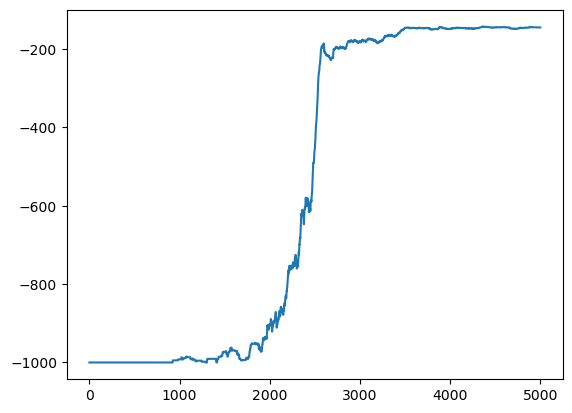

In [332]:
#training
train_env = gym.make('MountainCar-v0', render_mode="rgb_array")
q_learning_test(True,5000,train_env)

Before, we were just training the model. Now, lets test how good our Q-table really is. 

Here, we use the gym package to render the GUI, and do the same plot we did before, but this time, since the values are close together, we can cleary see we get a maximum of -145, meaning we can get our car to the top with 145 steps.(CHECAR ESTA CONCLUSAO)

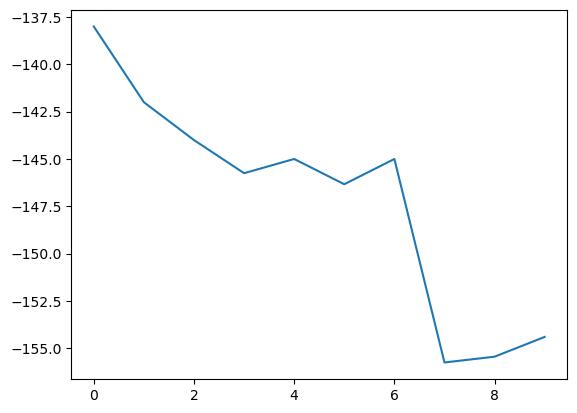

In [333]:

eval_env = gym.make('MountainCar-v0', render_mode="human")# will be rendered in a window or on the screen using the standard rendering mechanism (GUI) of the system
#test/evaluation
q_learning_test(False, 10,eval_env)

## Deep Q-Learning

* When a neural network is created it has a random set of weight and bias.

Again two environments are instantiated, one for training and one for evaluation/testing.

There are two ways of doing this, with tensorflow and pytorch.

In [120]:
#two environments instanciated
train_env_dql = gym.make('MountainCar-v0')

# Divide position and velocity into segments
position_space = np.linspace(train_env_dql.observation_space.low[0], train_env_dql.observation_space.high[0], 20)    # position between -1.2 and 0.6
velocity_space = np.linspace(train_env_dql.observation_space.low[1], train_env_dql.observation_space.high[1], 20)    # velocity between -0.07 and 0.07

ACTIONS = [0, 1, 2]             # 0=push left, 1=no push, 2=push right, chage to Letters if needed

train_env_dql.observation_space.shape[0]

2

#### Auxiliar functions

In [76]:
# Define model
class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()

        # Define network layers
        self.fc1 = nn.Linear(in_states, h1_nodes)   # first fully connected layer
        self.out = nn.Linear(h1_nodes, out_actions) # ouptut layer w

    def forward(self, x):
        x = F.relu(self.fc1(x)) # Apply rectified linear unit (ReLU) activation
        x = self.out(x)         # Calculate output
        return x

'''
Converts an state (int) to a tensor representation.
For example, the FrozenLake 4x4 map has 4x4=16 states numbered from 0 to 15. 

Parameters: state=5, num_states=16
Return: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
'''
def state_to_dqn_input(state:int, num_states:int)->torch.Tensor:
    input_tensor = torch.zeros(num_states)
    input_tensor[state] = 1
    return input_tensor


# Print DQN: state, best action, q values
def print_dqn(dqn):
    # Get number of input nodes
    num_states = dqn.fc1.in_features
    print(num_states)

    # Loop each state and print policy to console
    for s in range(num_states):
        #  Format q values for printing
        q_values = ''
        for q in dqn(state_to_dqn_input(s, num_states)).tolist():
            q_values += "{:+.2f}".format(q)+' '  # Concatenate q values, format to 2 decimals
        q_values=q_values.rstrip()              # Remove space at the end

        # Map the best action to L D R U
        best_action = dqn(state_to_dqn_input(s, num_states)).argmax()

        # Print policy in the format of: state, action, q values
        # The printed layout matches the FrozenLake map.
        print(f'{s:02},{best_action},[{q_values}]', end=' ')         
        if (s+1)%4==0:
            print() # Print a newline every 4 states




# Optimize policy network
def optimize(mini_batch, policy_dqn, target_dqn, discount_factor_g, loss_fn, optimizer):
    # Get number of input nodes
    num_states = policy_dqn.fc1.in_features

    current_q_list = []
    target_q_list = []

    for state, action, new_state, reward, terminated in mini_batch:

        if terminated: 
            # When in a terminated state, target q value should be set to the reward.
            target = torch.FloatTensor([reward])
        else:
            # Calculate target q value 
            with torch.no_grad():
                target = torch.FloatTensor(
                    reward + discount_factor_g * target_dqn(state_to_dqn_input(new_state, num_states)).max()
                )

        # Get the current set of Q values
        current_q = policy_dqn(state_to_dqn_input(state, num_states))
        current_q_list.append(current_q)

        # Get the target set of Q values
        target_q = target_dqn(state_to_dqn_input(state, num_states)) 
        # Adjust the specific action to the target that was just calculated
        target_q[action] = target
        target_q_list.append(target_q)
            
    # Compute loss for the whole minibatch
    loss = loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


#### 

In [107]:
#function for the deep q-learning algorithm
def deep_q_learning_training(episodes):
    #hyperparameters 
    learning_rate_a = 0.001         # learning rate (alpha)
    discount_factor_g = 0.9         # discount rate (gamma)    
    network_sync_rate = 10          # number of steps the agent takes before syncing the policy and target network
    replay_memory_size = 1000       # size of replay memory
    mini_batch_size = 32            # size of the training data set sampled from the replay memory

    random_n_g = np.random.default_rng()   # random number generator
    n_states = train_env_dql.observation_space.shape[0] #len(position_space) + len(velocity_space)# the neural network must kow the dimensions correctly #train_env_dql.observation_space.shape[0]
    n_actions = train_env_dql.action_space.n

    # Neural Network
    loss_fn = nn.MSELoss()          # NN Loss function. MSE=Mean Squared Error can be swapped to something else.
    optimizer = None                # NN Optimizer. Initialize later.

    epsilon = 1 # as before epsilon = 1 is 100% random actions


    #replay memory
    replay_mem = deque([], maxlen=replay_memory_size)

    # Create policy and target network. Number of nodes in the hidden layer can be adjusted.
    policy_dqn = DQN(in_states=n_states, h1_nodes=n_states, out_actions=n_actions)
    target_dqn = DQN(in_states=n_states, h1_nodes=n_states, out_actions=n_actions)
    #target_dqn = nn.Linear(n_states,n_actions)

    # Make the target and policy networks the same (copy weights/biases from one network to the other)
    target_dqn.load_state_dict(policy_dqn.state_dict())
    
    print('Policy (random, before training):')
    print_dqn(policy_dqn)

    # Policy network optimizer Adam
    optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=learning_rate_a)

    # List to keep track of rewards collected per episode. Initialize list to 0's.
    rewards_per_episode = np.zeros(episodes)

    # List to keep track of epsilon decay
    epsilon_history = []

    # Track number of steps taken. Used for syncing policy => target network.
    step_count = 0

    for i in range(episodes):
        state = train_env_dql.reset()  # Initialize to initial state
        #state_p = np.digitize(state[0], position_space) #digitize function to find which segment the value belongs to
        #state_v = np.digitize(state[1], velocity_space)
        terminated = False   # True when episode is terminated

        rewards = 0 # each reward is -1

        # Agent takes actions until the episode is terminated
        while (not terminated and rewards>-1000):
            # Select action based on epsilon-greedy
            if random_n_g.random() < epsilon:
                action = train_env_dql.action_space.sample()
            else:
                with torch.no_grad():
                    # Compute Q-values using the policy network
                    q_values = policy_dqn(state_to_dqn_input(state, n_states))

                    # Extract the action as a scalar
                    action = q_values.argmax().item()

            # Execute action
            new_state, reward, terminated,_,_= train_env_dql.step(action)

            #new_state_p = np.digitize(new_state[0], position_space)
            #new_state_v = np.digitize(new_state[1], velocity_space)

            # Save experience into memory
            replay_mem.append((state, action, new_state, reward, terminated))

            # Move to the next state
            state = new_state
            #state_p = new_state_p
            #state_v = new_state_v

            # Increment step counter
            step_count += 1

            rewards+=reward

        # Keep track of the rewards collected per episode.
        rewards_per_episode[i] = reward

        # Check if enough experience has been collected
        if len(replay_mem) > mini_batch_size:
            mini_batch = r.sample(replay_mem, mini_batch_size)
            optimize(mini_batch, policy_dqn, target_dqn,discount_factor_g,loss_fn,optimizer)

            # Decay epsilon
            epsilon = max(epsilon - 1 / episodes, 0)
            epsilon_history.append(epsilon)

            # Copy policy network to target network after a certain number of steps
            if step_count > network_sync_rate:
                target_dqn.load_state_dict(policy_dqn.state_dict())
                step_count = 0
    
    # Close environment
    train_env_dql.close()

    # Save policy
    torch.save(policy_dqn.state_dict(), "mountain_car_dql.pt")

    # Create new graph
    plt.figure(1)

    # Plot average rewards (Y-axis) vs episodes (X-axis)
    sum_rewards = np.zeros(episodes)
    for x in range(episodes):
        sum_rewards[x] = np.sum(rewards_per_episode[max(0, x - 100):(x + 1)])
    plt.subplot(121)  # plot on a 1 row x 2 col grid, at cell 1
    plt.plot(sum_rewards)

    # Plot epsilon decay (Y-axis) vs episodes (X-axis)
    plt.subplot(122)  # plot on a 1 row x 2 col grid, at cell 2
    plt.plot(epsilon_history)

    # Save plots
    plt.savefig('mountain_car_dql.png')



In [108]:
#training 
deep_q_learning_training(5000)

Policy (random, before training):
2
00,1,[-0.60 +0.67 +0.32] 01,1,[-0.86 +0.78 +0.36] 

IndexError: too many indices for tensor of dimension 1

In [91]:
# Run the Mountain Car environment with the learned policy
def deep_q_learning_test(episodes):
    # Create Mountain Car instance
    eval_env_dql = gym.make('MountainCar-v0', render_mode="human")
    n_states = len(position_space) + len(velocity_space)
    n_actions = eval_env_dql.action_space.n

    # Load learned policy
    policy_dqn = DQN(in_states=n_states, h1_nodes=n_states, out_actions=n_actions)
    policy_dqn.load_state_dict(torch.load("mountain_car_dql.pt"))
    policy_dqn.eval()    # switch model to evaluation mode

    

    print('Policy (trained):')
    print_dqn(policy_dqn)

    for i in range(episodes):
        state = eval_env_dql.reset()[0]  # Initialize to state 0
        terminated = False      # True when agent falls in hole or reached goal        

        rewards = 0 # each reward is -1

        # Agent navigates map until it reaches the goal (flag) or it rewaches a reward of -1000
        while(not terminated and rewards>-1000):  
            # Select best action   
            with torch.no_grad():
                action = policy_dqn(state_to_dqn_input(state, n_states)).argmax().item()

            # Execute action
            state,reward,terminated,_ = env.step(action)

            rewards+=reward

    eval_env_dql.close()

In [44]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

# Neural network model
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Experience replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.FloatTensor(states),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(next_states),
            torch.BoolTensor(dones)
        )

    def __len__(self):
        return len(self.buffer)

# Deep Q-Learning agent
class DQNAgent:
    def __init__(self, env, buffer_capacity=10000, batch_size=64, gamma=0.99, lr=1e-3, epsilon_decay=0.995):
        self.env = env
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.buffer = ReplayBuffer(buffer_capacity)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = epsilon_decay
        self.model = DQN(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.target_model = DQN(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def select_action(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()  # Explore
        else:
            with torch.no_grad():
                q_values = self.model(torch.FloatTensor(state).to(self.device))
                return q_values.argmax().item()  # Exploit

    def train(self):
        if len(self.buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)

        current_q_values = self.model(states).gather(1, actions.unsqueeze(1))
        target_q_values = rewards.unsqueeze(1) + self.gamma * (~dones.unsqueeze(1)) * \
                  self.target_model(next_states).max(1)[0].unsqueeze(1)


        loss = self.loss_fn(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

        

    def train_agent(self, episodes=1000, target_update_frequency=10):
        total_rewards = []

        for episode in range(episodes):
            state = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                action = self.select_action(state)
                next_state, reward, done, _ = self.env.step(action)

                self.buffer.push((state, action, reward, next_state, done))
                self.train()

                state = next_state
                total_reward += reward

            total_rewards.append(total_reward)

            if episode % target_update_frequency == 0:
                self.update_target_model()

            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

            if episode % 10 == 0:
                print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {self.epsilon}")

        return total_rewards

    def test_agent(self, episodes=10):
        for episode in range(episodes):
            state = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                self.env.render()
                action = self.select_action(state)
                state, reward, done, _ = self.env.step(action)
                total_reward += reward

            print(f"Test Episode {episode}, Total Reward: {total_reward}")

# Create Mountain Car environment
env = gym.make('MountainCar-v0')

# Initialize DQNAgent
agent = DQNAgent(env)

# Train the agent
total_rewards = agent.train_agent(episodes=500)

# Test the agent
agent.test_agent()

# Close the environment
env.close()


Episode 0, Total Reward: -200.0, Epsilon: 0.995
Episode 10, Total Reward: -200.0, Epsilon: 0.946354579813443
Episode 20, Total Reward: -200.0, Epsilon: 0.9000874278732445
Episode 30, Total Reward: -200.0, Epsilon: 0.8560822709551227
Episode 40, Total Reward: -200.0, Epsilon: 0.8142285204175609
Episode 50, Total Reward: -200.0, Epsilon: 0.7744209942832988
Episode 60, Total Reward: -200.0, Epsilon: 0.736559652908221
Episode 70, Total Reward: -200.0, Epsilon: 0.7005493475733617
Episode 80, Total Reward: -200.0, Epsilon: 0.6662995813682115
Episode 90, Total Reward: -200.0, Epsilon: 0.6337242817644086
Episode 100, Total Reward: -200.0, Epsilon: 0.6027415843082742
Episode 110, Total Reward: -200.0, Epsilon: 0.5732736268885887
Episode 120, Total Reward: -200.0, Epsilon: 0.5452463540625918
Episode 130, Total Reward: -200.0, Epsilon: 0.5185893309484582
Episode 140, Total Reward: -200.0, Epsilon: 0.4932355662165453
Episode 150, Total Reward: -200.0, Epsilon: 0.46912134373457726
Episode 160, Tota

TypeError: MountainCarEnv.__init__() got an unexpected keyword argument 'render'

Policy (random, before training):
00,0,[+0.81 -0.19 -0.45] 01,0,[+1.57 -2.77 +0.35] Policy (trained):
00,0,[+0.81 -0.19 -0.45] 01,0,[+1.57 -2.77 +0.35] 

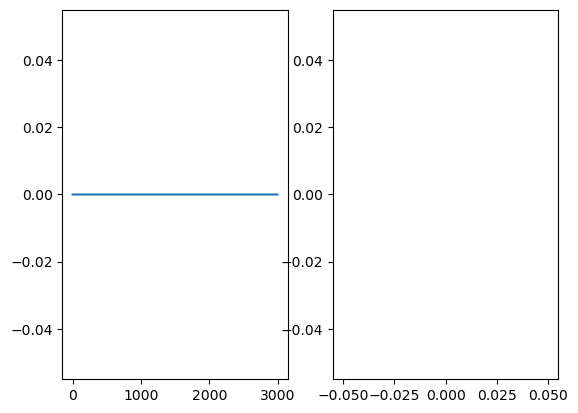

In [115]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F

# Define model
class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()

        # Define network layers
        self.fc1 = nn.Linear(in_states, h1_nodes)
        self.out = nn.Linear(h1_nodes, out_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    
    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

# Mountain Car Deep Q-Learning
class MountainCarDQL():
    # Hyperparameters (adjustable)
    learning_rate_a = 0.001
    discount_factor_g = 0.9
    network_sync_rate = 10
    replay_memory_size = 1000
    mini_batch_size = 32

    loss_fn = nn.MSELoss()
    optimizer = None

    ACTIONS = [0, 1, 2]  # 0: push left, 1: no push, 2: push right

    def __init__(self):
        self.state_low = [-1.2, -0.07]
        self.state_high = [0.6, 0.07]

    def train(self, episodes, render=False):
        env = gym.make('MountainCar-v0')
        num_states = env.observation_space.shape[0]
        num_actions = len(self.ACTIONS)

        epsilon = 1
        memory = ReplayMemory(self.replay_memory_size)

        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)
        target_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)
        target_dqn.load_state_dict(policy_dqn.state_dict())

        print('Policy (random, before training):')
        self.print_dqn(policy_dqn)

        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        rewards_per_episode = np.zeros(episodes)
        epsilon_history = []
        step_count = 0

        for i in range(episodes):
            state = env.reset()
            terminated = False
            truncated = False

            state = self.normalize_state(state)

            while not terminated and not truncated:
                if random.random() < epsilon:
                    action = random.choice(self.ACTIONS)
                else:
                    with torch.no_grad():
                        q_values = policy_dqn(torch.FloatTensor(state)).numpy()
                        action = np.argmax(q_values)

                new_state, reward, terminated, _ = env.step(self.ACTIONS[action])
                new_state = self.normalize_state(new_state)

                memory.append((state, action, new_state, reward, terminated))

                state = new_state
                step_count += 1

            if reward == 1:
                rewards_per_episode[i] = 1

            if len(memory) > self.mini_batch_size and np.sum(rewards_per_episode) > 0:
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)

                epsilon = max(epsilon - 1 / episodes, 0)
                epsilon_history.append(epsilon)

                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count = 0

        env.close()

        torch.save(policy_dqn.state_dict(), "mountain_car_dql.pt")

        plt.figure(1)
        sum_rewards = np.zeros(episodes)
        for x in range(episodes):
            sum_rewards[x] = np.sum(rewards_per_episode[max(0, x - 100):(x + 1)])
        plt.subplot(121)
        plt.plot(sum_rewards)
        plt.subplot(122)
        plt.plot(epsilon_history)
        plt.savefig('mountain_car_dql.png')

    def optimize(self, mini_batch, policy_dqn, target_dqn):
        num_states = policy_dqn.fc1.in_features

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:
            if terminated:
                target = torch.FloatTensor([reward])
            else:
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(torch.FloatTensor(new_state)).max()
                    )

            current_q = policy_dqn(torch.FloatTensor(state))
            current_q_list.append(current_q)

            target_q = target_dqn(torch.FloatTensor(state))
            target_q[action] = target
            target_q_list.append(target_q)

        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def state_to_dqn_input(self, state):
        return torch.FloatTensor(state)

    def normalize_state(self, state):
        normalized_state = (state - np.array(self.state_low)) / (np.array(self.state_high) - np.array(self.state_low))
        return normalized_state

    def test(self, episodes):
        env = gym.make('MountainCar-v0')
        num_states = env.observation_space.shape[0]
        num_actions = len(self.ACTIONS)

        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)
        policy_dqn.load_state_dict(torch.load("mountain_car_dql.pt"))
        policy_dqn.eval()

        print('Policy (trained):')
        self.print_dqn(policy_dqn)

        for i in range(episodes):
            state = env.reset()
            state = self.normalize_state(state)
            terminated = False
            truncated = False

            while not terminated and not truncated:
                with torch.no_grad():
                    q_values = policy_dqn(torch.FloatTensor(state)).numpy()
                    action = np.argmax(q_values)

                new_state, _, terminated, _ = env.step(self.ACTIONS[action])
                new_state = self.normalize_state(new_state)

                state = new_state

        env.close()

    def print_dqn(self, dqn):
        num_states = dqn.fc1.in_features

        for s in range(num_states):
            q_values = ''
            for q in dqn(torch.FloatTensor(self.normalize_state([s]))).tolist():
                q_values += "{:+.2f}".format(q) + ' '
            q_values = q_values.rstrip()

            best_action = self.ACTIONS[dqn(torch.FloatTensor(self.normalize_state([s]))).argmax()]

            print(f'{s:02},{best_action},[{q_values}]', end=' ')
            if (s + 1) % 4 == 0:
                print()

if __name__ == '__main__':
    mountain_car = MountainCarDQL()
    mountain_car.train(3000)
    mountain_car.test(10)


In [123]:
import gym
import numpy as np 
import matplotlib.pyplot as plt
import time
import random
from collections import deque
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import Sequential 
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import math


class Model:
    def __init__(self, input_dim, output_dim, lr):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.Qpolicy = self.create()
        self.Qtarget = self.create() 
        self.Qtarget.set_weights(self.Qpolicy.get_weights())
        
    def create(self):
        model = Sequential()
        model.add(Dense(512, input_dim = self.input_dim, activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(self.output_dim, activation = 'linear'))
        model.compile(optimizer = RMSprop(lr = self.lr, rho = 0.95, epsilon = 0.01), loss = "mse", metrics = ['accuracy'])
        return model

class DQNAgent:
    def __init__(self, lr = 2.5e-4, gamma = 0.99, epsilon = 1, decay_coe = 0.99975, min_eps = 0.001, 
                 batch_size = 64, memory_size = 10_000, episodes = 5_000, C = 5):
        
        self.env = gym.make('MountainCar-v0')

        self.states = len(env.observation_space.low)
        self.n_actions = env.action_space.n
        
        self.actions = [i for i in range(self.n_actions)]
        
        self.lr = lr 
        self.gamma = gamma
        self.epsilon = epsilon 
        self.decay_coe = decay_coe
        self.min_eps = min_eps
        self.episodes = episodes
        self.batch_size = batch_size
        self.D = deque(maxlen = memory_size) # replay memory 
        self.C = C
        
        self.terminal_state = False # end of the episode
        self.target_counter = 0 
        
        # Plot data
        self.timestep = self.episodes / 10
        self.history = [] 
        self.reward_data = []
        self.epsilon_data = []
        
        
        
        self.model = Model(self.states, self.n_actions, self.lr)
        # Smooth epsilon 
        self.a = 0.35
        self.b = 0.1
        self.c = 0.01
        
    def state_shape(self,states):
        states = np.array(states)
        return states.reshape(-1,*states.shape)
    
    def decrement_epsilon(self, time):
        '''
        if self.epsilon > self.min_eps:
            self.epsilon *= self.decay_coe
        else:
            self.epsilon = self.min_eps
        '''
        s_time = (time - self.a*self.episodes) / (self.b*self.episodes) 
        cosh = np.cosh(math.exp(-s_time))
        self.epsilon = 1 - (1/cosh + (time*self.c/self.episodes))

    def update_D(self, s, a, r, s_, done):
        self.D.append([self.state_shape(s), a, r, self.state_shape(s_), done])
        
    def choose_action(self, states):
        if np.random.random() > (1 - self.epsilon):
            action = np.random.choice(self.actions)
        else:
            states = self.state_shape(states)
            action = np.argmax(self.model.Qpolicy.predict(states))
            
        return action
            
    def minibatch(self):
        return random.sample(self.D, self.batch_size)
    
    def graphs(self, episode):
        f1 = plt.figure(1)
        plt.plot([i for i in range(len(self.reward_data))], self.reward_data)
        plt.ylabel('Score per episode')
        plt.xlabel('Episodes')
        plt.savefig(r'RL/reward - e{}v2.png'.format(episode), dpi = 500)
        
        f2 = plt.figure(2)
        plt.plot([i for i in range(len(self.epsilon_data))], self.epsilon_data)
        plt.ylabel('Epsilon')
        plt.xlabel('Episodes')
        plt.savefig(r'RL/epsilon - e{}v2.png'.format(episode), dpi = 500)
        
        f3 = plt.figure(3)
        plt.plot([i for i in range(len(self.history))], self.history)
        plt.ylabel('Loss')
        plt.xlabel('Iterations')
        plt.savefig(r'RL/loss - e{}v2.png'.format(episode), dpi = 500)
        
    def train(self):
        # X - states passed to the NN, y - target
        
        X, y = [], []
        
        if len(self.D) >= self.batch_size: 
            SARS = self.minibatch()
        
            s = self.state_shape([row[0] for row in SARS])
            qvalue = self.model.Qpolicy.predict(s)[0]

            s_ = self.state_shape([row[3] for row in SARS])
            future_qvalue = self.model.Qtarget.predict(s_)[0]

            for index, (state, action, reward, state_, done) in enumerate(SARS):
                if done == True:
                    Qtarget = reward
                else:
                    Qtarget = reward + self.gamma * np.max(future_qvalue[index])
            
                
                qcurr = qvalue[index][0]
                qcurr[action] = Qtarget                
                X.append(state)
                y.append(qcurr)
                
            X, y = np.array(X).reshape(1,self.batch_size,1,self.states), np.array(y).reshape(1,self.batch_size, 1, self.n_actions)
                                        
            loss = self.model.Qpolicy.fit(X, y, batch_size = self.batch_size, shuffle = False, verbose = 0)
            self.history.append(loss.history['loss'][0])
            
                
            if self.terminal_state:
                self.target_counter+=1

            # C -> target network update frequency
            if self.target_counter > self.C: 
                self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
                self.target_counter = 0 
            
        
    def training(self):
        timestep_reward = 0
        
        for episode in tqdm(range(1, self.episodes+1), ascii = True, unit = 'episode'): 
            s = self.env.reset()
            done = False
            score = 0
            while done != True:
                a = self.choose_action(s)
                
                s_, r, done, _= self.env.step(a)
                
                # Update 
                self.terminal_state = done
                self.update_D(s,a,r,s_,done)
                
                self.train()
                
                s = s_
                score += r
                
            self.decrement_epsilon(episode)  

            # UPDATE
            self.reward_data.append(score)
            self.epsilon_data.append(self.epsilon)
            
            if episode % self.timestep == 0: 
                self.graphs(episode)
            
         
        
        self.graphs(episode)
        self.model.Qpolicy.save(r'RL/{}'.format())
        
    def test(self, model_name,test_episodes = 100):
        model = tf.keras.models.load_model('{}'.format(model_name))
        reward = []
        self.epsilon = 0.05
        for i in range(test_episodes):
            ep_reward = 0
            s = self.env.reset()
            done = False

            while done != True:
                if np.random.random() > self.epsilon: 
                    
                    s_, r, done, _ = self.env.step(a)
                    
                    s = s_
                    ep_reward += r  
                    
            reward.append(ep_reward)
        
        plt.plot([i for i in range(len(reward))], reward)
        plt.xlabel('Episodes')
        plt.ylabel('Episode reward')
        plt.savefig(r'RL/Test.png')

In [124]:
dqn = DQNAgent(episodes = 1_000)
dqn.training()

  0%|          | 0/1000 [00:00<?, ?episode/s]


ValueError: in user code:

    File "C:\Users\guilh\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\guilh\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\guilh\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\guilh\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "C:\Users\guilh\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\guilh\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 64, 1, 2)
